In [2]:
import music21

In [3]:
from music21 import converter, instrument, note, chord

def read_midi(file):

  notes = []
  notes_to_parse = None

  midi = converter.parse(file)

  s2 = instrument.partitionByInstrument(midi)

  for part in s2.parts:

    if "Piano" in str(part):

      notes_to_parse = part.recurse()

      for element in notes_to_parse:

        if isinstance(element, note.Note):
          notes.append(str(element.pitch))

        elif isinstance(element, chord.Chord):
          notes.append(".".join(str(n) for n in element.normalOrder))

  return np.array(notes)            

In [6]:
import os
import numpy as np

path = "/content/"

files = [i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path + i) for i in files])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [7]:
notes_ = [element for note_ in notes_array for element in note_]

unique_notes = list(set(notes_))
print(len(unique_notes))

316


(array([223.,  36.,  16.,   6.,   7.,  12.,   4.,   5.,   6.,   1.]),
 array([1.000e+00, 1.510e+02, 3.010e+02, 4.510e+02, 6.010e+02, 7.510e+02,
        9.010e+02, 1.051e+03, 1.201e+03, 1.351e+03, 1.501e+03]),
 <a list of 10 Patch objects>)

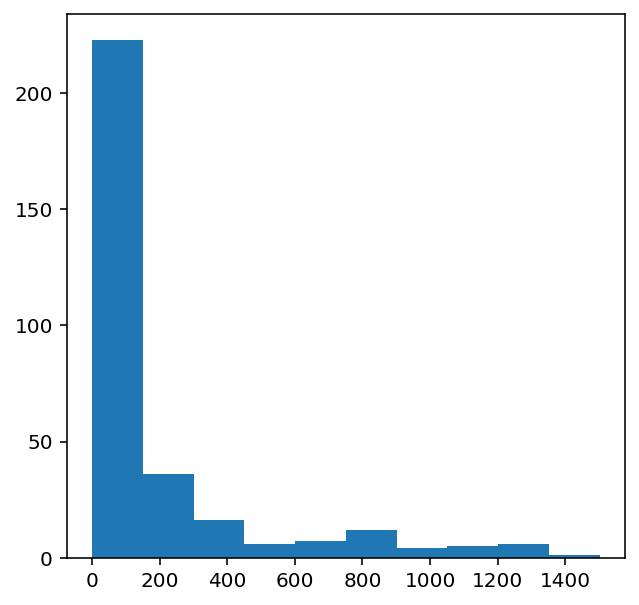

In [8]:
from collections import Counter
freq = dict(Counter(notes_))

import matplotlib.pyplot as plt

no = [count for _, count in freq.items()]

plt.figure(figsize=(5,5))

plt.hist(no)

In [9]:
frequent_notes = [note_ for note_, count in freq.items() if count>= 50]
print(len(frequent_notes))

146


In [10]:
new_music = []

for notes in notes_array:
  temp = []
  for note_ in notes:
    if note_ in frequent_notes:
      temp.append(note_)
  new_music.append(temp)

new_music = np.array(new_music)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [15]:
timesteps = 32
x = []
y = []

for note_ in new_music:
  for i in range(0, len(note_) - timesteps, 1):

    input_ = note_[i : i + timesteps]
    output_ = note_[i + timesteps]

    x.append(input_)
    y.append(output_)

x = np.array(x)
y = np.array(y)    

In [16]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [25]:
x_seq = []

for i in x:
  temp = []
  for j in i:
    temp.append(x_note_to_int[j])
  x_seq.append(temp)

x_seq = np.array(x_seq)   

In [39]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y))
y_seq = np.array([y_note_to_int[i] for i in y])

In [40]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq, y_seq, test_size = 0.2, random_state=42)

In [50]:
x_tr = np.array(x_tr)
x_val = np.array(x_val)

x_tr = np.expand_dims(x_tr, 1)
x_val = np.expand_dims(x_val, 1)

In [62]:
x_tr = x_tr.astype("float32")
x_val = x_val.astype("float32")
y_tr = y_tr.astype("float32")
y_val = y_val.astype("float32")

In [63]:
x_tr.dtype

dtype('float32')

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

num_notes = len(frequent_notes)

def lstm():
  model = Sequential()
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256, activation="relu"))
  model.add(Dense(num_notes, activation="softmax"))
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
  return model

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint("best_model.h5", monitop="val_loss", mode="min", save_best_only=True, verbose=1)

In [64]:
history = lstm().fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val), verbose=1, callbacks=[mc])

Epoch 1/50
340/340 [==============================] - 12s 10ms/step - loss: 4.6210 - val_loss: 4.6043

Epoch 00001: val_loss improved from inf to 4.60426, saving model to best_model.h5
Epoch 2/50
340/340 [==============================] - 2s 7ms/step - loss: 4.5930 - val_loss: 4.5904

Epoch 00002: val_loss improved from 4.60426 to 4.59040, saving model to best_model.h5
Epoch 3/50
340/340 [==============================] - 2s 7ms/step - loss: 4.5791 - val_loss: 4.5797

Epoch 00003: val_loss improved from 4.59040 to 4.57966, saving model to best_model.h5
Epoch 4/50
340/340 [==============================] - 2s 7ms/step - loss: 4.5627 - val_loss: 4.5692

Epoch 00004: val_loss improved from 4.57966 to 4.56917, saving model to best_model.h5
Epoch 5/50
340/340 [==============================] - 2s 7ms/step - loss: 4.5529 - val_loss: 4.5506

Epoch 00005: val_loss improved from 4.56917 to 4.55061, saving model to best_model.h5
Epoch 6/50
340/340 [==============================] - 2s 7ms/step -

In [65]:
from keras.models import load_model
model = load_model("best_model.h5")